In [146]:
# importing Qiskit
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_provider import IBMProvider
import random

In [147]:
api_token='IBM TOKEN'

# IBMProvider.save_account(api_token, overwrite=True)
# provider = IBMProvider()
# print("Available backends:", provider.backends())

In [148]:
def generateRandomState(n,delta):
     nQubits = int((4 + delta)*n) 
     basis = np.random.randint(2, size=(nQubits,))
     return basis

In [149]:
class Alice:
    def prepareState(self,n,delta):
        alice_data_state=generateRandomState(n,delta)
        alice_basis_state=generateRandomState(n,delta)
        return (alice_data_state,alice_basis_state)    
    

In [150]:
class Bob:
    def getBasis(self,n,delta):
        return generateRandomState(n,delta)

class Eve:
    def getBasis(self,n,delta):
        return generateRandomState(n,delta)


In [156]:
def BB84Algorithm(key_length):
    n = key_length
    
    # error delta
    delta = 0

    nQubits = int((4 + delta)*n)

    bb_circuit= QuantumCircuit(nQubits,nQubits)
    bb_circuit_eve= QuantumCircuit(nQubits,nQubits)

    alice = Alice()
    bob = Bob()
    eve = Eve()

    (alice_data_state,alice_basis_state) = alice.prepareState(n,delta)


    # alice initial secret key that she want to share with bob
    print("alice  data  : ",alice_data_state)

    # alice random basis in which she will incode the qubits
    print("alice basis  : ",alice_basis_state)


    ######################## Alice Side State Generation ##########################

    # prepare the quantum initial state as per the alice secret key array for both circuit one with eve and another without eve     
    for idx in range(nQubits):
        if(alice_data_state[idx]==1):
            bb_circuit.x(idx)
            bb_circuit_eve.x(idx)
    # Apply hadamard gate on the initial state on the basis of "alice random choosen basis" this will switch the qubit state from |0> and |1> to |+> and |-> 
    for idx in range(nQubits):
        if(alice_basis_state[idx]==1):
            bb_circuit.h(idx)
            bb_circuit_eve.h(idx)

    bb_circuit.barrier()
    bb_circuit_eve.barrier()



    ######################## Bob Side State measurement ##########################

    # Bob will pick a random basis to measure the bits shared by alice
    bob_basis_state = bob.getBasis(n,delta)
    print("bob basis    : ",bob_basis_state)

    # Eve will also pick a random basis to measure the bits shared by alice (if present)
    eve_basis_state = eve.getBasis(n,delta)
    print("eve basis    : ",eve_basis_state)


    # Eve is doing measurement using its random basis if present
    for idx in range(nQubits):
        if(eve_basis_state[idx]==1):
            bb_circuit_eve.h(idx)

    bb_circuit_eve.barrier()
    # Bob is doing measurement using its random basis if present
    for idx in range(nQubits):
        if(bob_basis_state[idx]==1):
            bb_circuit.h(idx)
            bb_circuit_eve.h(idx)

    for idx in range(nQubits):
        bb_circuit.measure(idx,idx)
        bb_circuit_eve.measure(idx,idx)
    return (bb_circuit,bb_circuit_eve,alice_data_state,alice_basis_state,bob_basis_state)




In [165]:
(bb_circuit,bb_circuit_eve,alice_data_state,alice_basis_state,bob_basis_state)=BB84Algorithm(2)


alice  data  :  [1 1 0 1 0 0 1 1]
alice basis  :  [1 0 1 1 0 1 1 0]
bob basis    :  [0 1 0 0 0 1 1 0]
eve basis    :  [0 1 0 0 1 1 1 1]


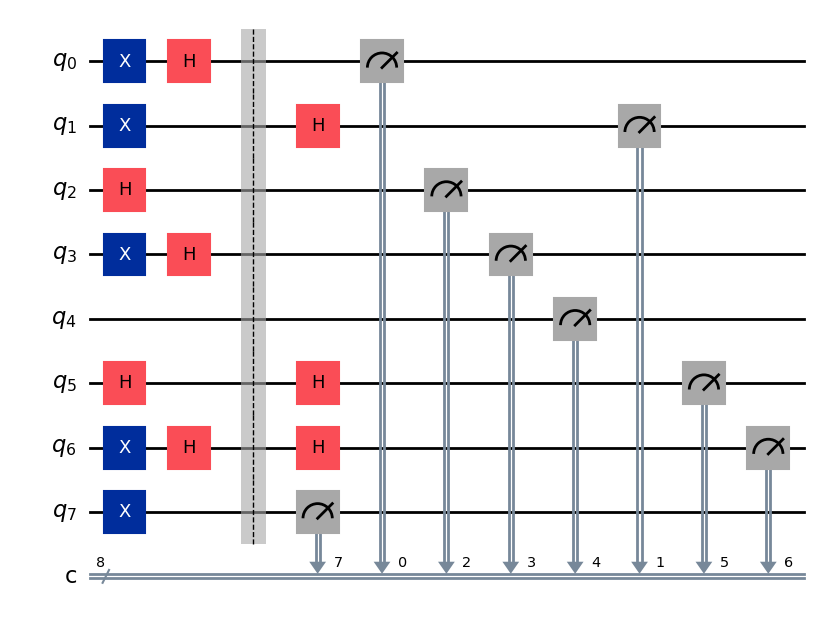

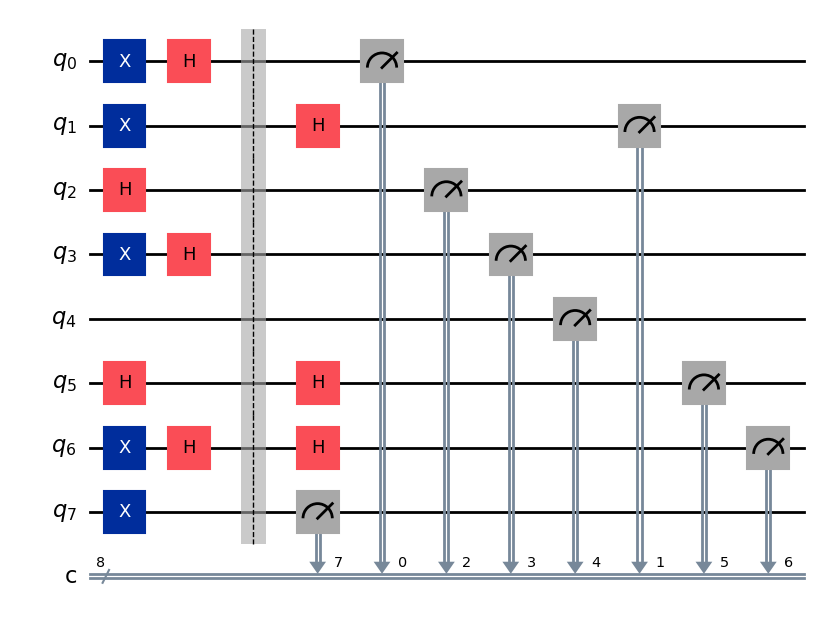

In [166]:
# Circuit without eve
bb_circuit.draw(output="mpl")


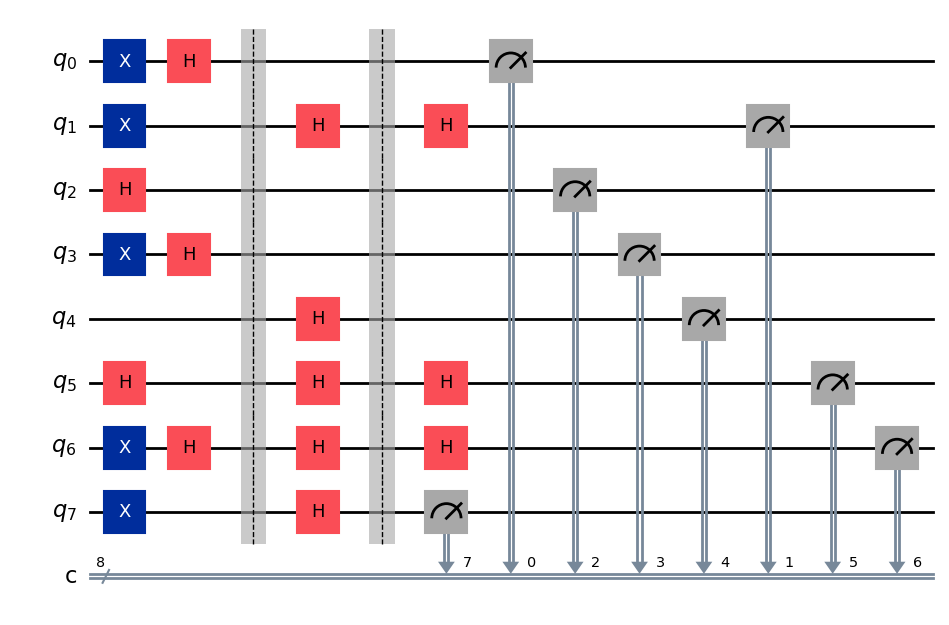

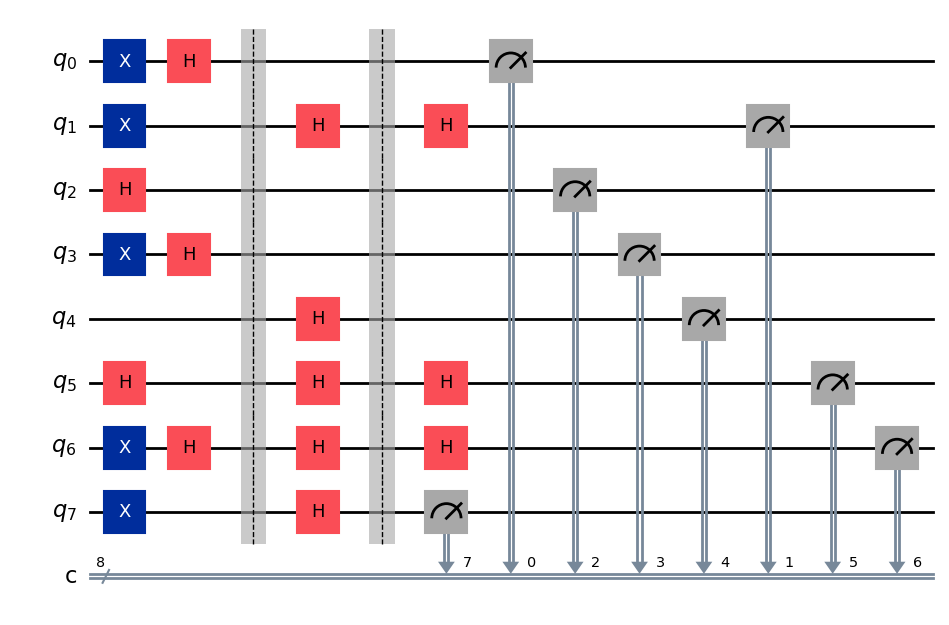

In [167]:
# Circuit with eve
bb_circuit_eve.draw(output="mpl")


In [245]:
def determineSecretKey(alice_data,bob_measurement,alice_basis_state,bob_basis_state,n):

    # Alice will announce its basis and bob will discard all the qubits on which their bases does not match
    
    matching_basis= [alice_basis_state_idx==bob_basis_state_idx for (alice_basis_state_idx,bob_basis_state_idx) in zip(alice_basis_state,bob_basis_state)]
    matching_basis = np.array(matching_basis)
    # The matching bases is now shared to alice also over public channel
    print(bob_measurement)
    print(matching_basis)
    # Now if less than half of alice chosen basis and bob randomly pick bases are matching then will discard the protocol.
    
    if(np.sum(matching_basis)<2*n):
        print("Aborting the protocol: Less then half of the alice and bob basis matches")
        return False
    

    # Alice and Bob will only keep the data bits if their measurement basis matched.
    alice_data_matching = alice_data[matching_basis]
    bob_measurement_matching = bob_measurement[matching_basis]


    # Alice and Bob will select half of the bits as check bits and use the remaining half as the secure key.

    check_bit_alice = alice_data_matching[:n]
    data_secret_bit_alice = alice_data_matching[-n:]

    check_bit_bob = bob_measurement_matching[:n]


    # Check the count of bits which are not matching from check bits between alice and bob
    mismatch_bit = [check_bit_alice_idx != check_bit_bob_idx for(check_bit_alice_idx,check_bit_bob_idx) in zip(check_bit_alice,check_bit_bob)]
    print(alice_data_matching)
    print(bob_measurement_matching)
    print(check_bit_alice)
    print(check_bit_bob)
    print(mismatch_bit)
    error = (np.sum(mismatch_bit)) / n
    print("error ",error)
    # Let's choose epsilon = 0.05 as our error threshold
    epsilon = 0.05

    # Alice and bob will abort the protocol if error during transmission is more than specified epsilon(error due to other factors)
    
    if error > epsilon:
        print("Interference detected while sharing the secret... Aborting the protocol!")
        return False
    else:
        print("Successfully exchanged secret key: ", data_secret_bit_alice)
        return True

In [246]:
from qiskit.exceptions import QiskitError

def most_freq(self):
    max_value = max(self.values())
    max_values_counts = [x[0] for x in self.items() if x[1] == max_value]
    
    if len(max_values_counts) != 1:
        # Handle the tie by picking the lexicographically smallest value
        selected_value = min(max_values_counts)
        return selected_value
    
    return max_values_counts[0]


In [253]:
def getMeasurement(answer, answer_eve):
    #bob_meas = list(random.choice(list(answer.keys())))
    bob_meas =  list(most_freq(answer))
    bob_meas = list(map(int, bob_meas))

  
    bob_meas = np.array(bob_meas)

    print("Bob's measurement result: ", bob_meas)
    
    # bob_meas_eve = list(random.choice(list(answer_eve.keys())))
    bob_meas_eve =  list(most_freq(answer_eve))
    
    bob_meas_eve = list(map(int, bob_meas_eve))
    
    bob_meas_eve = np.array(bob_meas_eve)

    
    print("Bob's measurement result with eavesdropping: ", bob_meas_eve)
    
    return (bob_meas, bob_meas_eve)
    
bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)

Bob's measurement result:  [0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0]
Bob's measurement result with eavesdropping:  [0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0]


In [281]:
def runCircuit(shots,key_length):
    aer_sim = Aer.get_backend('qasm_simulator')
    (bb_circuit,bb_circuit_eve,alice_data_state,alice_basis_state,bob_basis_state) = BB84Algorithm(key_length)
    print("Running simulation....")

    t_bb_circuit = transpile(bb_circuit.reverse_bits(), aer_sim)
    results = aer_sim.run(t_bb_circuit, shots=shots).result().get_counts()
    t_bb_circuit_eve = transpile(bb_circuit_eve.reverse_bits(), aer_sim)
    results_eve = aer_sim.run(t_bb_circuit_eve, shots=shots).result().get_counts()
    return (results,results_eve,alice_data_state,alice_basis_state,bob_basis_state)




In [282]:
(answer, answer_eve, alice_data_bit, alice_basis_state, bob_basis_state) = runCircuit(2**10, 6)

print("Discrete distribution of potential measurements by Bob: ", answer)
print("Discrete distribution of potential measurements by Bob with eavesdropping: ", answer_eve)

bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)

print("Key Exchange without eavesdropping: ")

res = determineSecretKey(alice_data_bit, bob_meas,alice_basis_state , bob_basis_state,6)
print("Key Exchange with eavesdropping: ")
res = determineSecretKey(alice_data_bit, bob_meas_eve,alice_basis_state , bob_basis_state,6)

alice  data  :  [0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
alice basis  :  [0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
bob basis    :  [0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1]
eve basis    :  [0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1]
Running simulation....
Discrete distribution of potential measurements by Bob:  {'001010101100001000100100': 2, '010010100110001010010100': 2, '011010100110001001110100': 1, '000010111110001011000100': 1, '000011100110001011100100': 1, '010110101100001011000100': 1, '010010100110001000110100': 1, '010011101110001000000100': 1, '001110110110001011100100': 1, '010010110110001010110100': 1, '011110111100001010000100': 2, '010010101110001011010100': 1, '011011101110001011110100': 1, '001010110100001011110100': 1, '011111101100001000010100': 2, '000111111100001001110100': 1, '010111100100001010100100': 1, '010111100110001011000100': 1, '010111110100001000000100': 1, '001010111110001011110100': 1, '001111110110001001000100': 1, '010

In [283]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_eve_undetected(probs):
    
    objects = ('2', '4', '6')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, probs, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    
    plt.xlabel("Secret of key length")
    plt.ylabel('Probability')
    plt.title('Probability of Undetected Eavesdropping')
    
    plt.show()

In [285]:
probs = []
for n in [2,4,6]:
    succ = 0
    succ_eve = 0
    fail = 0
    for i in range(2**7):
        print("Simulation round:", i)
        (answer, answer_eve, alice_data_bit, alice_basis_state, bob_basis_state) = runCircuit(2**11, n)
        bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)
        print("Key Exchange without eavesdropping: ")
        res = determineSecretKey(alice_data_bit, bob_meas, alice_basis_state, bob_basis_state,n)
        # successful
        if res: 
            succ += 1
        print("Key Exchange with eavesdropping: ")
        res = determineSecretKey(alice_data_bit, bob_meas_eve, alice_basis_state, bob_basis_state,n)
        # successful
        if res: 
            succ_eve += 1
    
        
    print("n=", n)
    print("Successful key exchanges without Eve present: ", succ)
    print("Successful key exchanges with Eve present: ", succ_eve)
    p = (succ_eve) / (2**7)
    probs.append(p)



Simulation round: 0
alice  data  :  [0 1 1 1 1 1 1 0]
alice basis  :  [0 0 0 0 0 0 0 1]
bob basis    :  [0 0 1 1 0 1 0 0]
eve basis    :  [0 1 1 1 0 0 1 1]
Running simulation....
Bob's measurement result:  [0 1 0 1 1 1 1 1]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 0 1 0]
Key Exchange without eavesdropping: 
[0 1 0 1 1 1 1 1]
[ True  True False False  True False  True False]
[0 1 1 1]
[0 1 1 1]
[0 1]
[0 1]
[False, False]
error  0.0
Successfully exchanged secret key:  [1 1]
Key Exchange with eavesdropping: 
[0 1 1 1 1 0 1 0]
[ True  True False False  True False  True False]
[0 1 1 1]
[0 1 1 1]
[0 1]
[0 1]
[False, False]
error  0.0
Successfully exchanged secret key:  [1 1]
Simulation round: 1
alice  data  :  [0 1 1 0 0 1 0 1]
alice basis  :  [0 1 0 0 0 1 1 0]
bob basis    :  [0 0 0 0 0 0 0 0]
eve basis    :  [1 0 0 0 1 0 1 0]
Running simulation....
Bob's measurement result:  [0 1 1 0 0 1 0 1]
Bob's measurement result with eavesdropping:  [1 0 1 0 1 0 0 1]
Key Exchange with

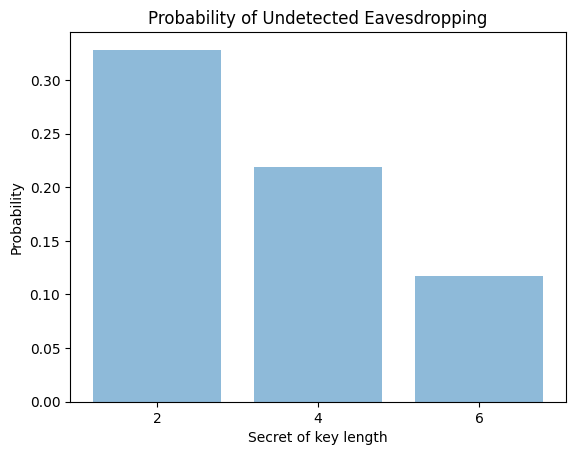

In [286]:
plot_eve_undetected(probs)